In [1]:
import numpy as np
import pandas as pd
import torch
from sklearn.feature_extraction.text import TfidfTransformer
import h5py
import yaml
import pickle
import os
import argparse
import random
from tqdm.notebook import tqdm
from collections import Counter
from dataclasses import dataclass, field
import contextlib
import math

In [2]:
data = pd.read_csv('../processed_data/utrs.csv')
data = data[['Gene Name', 'foreign']].dropna(axis=0).rename(columns={'Gene Name': 'gene', 'foreign':'seq'})

In [3]:
data.head()

,gene,seq
4,VPS8,ACATTTCTAAATATTTAATACAACTTTGGTTACATAAAAGTAAAAT...
5,SSA1,AGCCAATTGGTGCGGCAATTGATAATAACGAAAATGTCTTTTAATG...
6,ERP2,AGAACTTTTCAATCTACGAAAAATATATGTCCGCAATATAGAACAC...
7,FUN14,AGCAAGACAAATGACCAGATATAAACGAGGGTTATATTCTTTCGTT...
8,SPO7,AAAGAGTTGGAGGGCTTCTTCCTTCGAATAAGAGGTCATATTTACC...


In [4]:

def entropy(string):
    "Calculates the Shannon entropy of a string"

    # get probability of chars in string
    prob = [ float(string.count(c)) / len(string) for c in dict.fromkeys(list(string)) ]

    # calculate the entropy
    entropy = - sum([ p * math.log(p) / math.log(2.0) for p in prob ])

    return min(1, abs(entropy) / 2)

In [53]:
from itertools import product

In [57]:
list(product([['a', 'b'], ['c', 'd']]))

[(['a', 'b'],), (['c', 'd'],)]

In [65]:
kmer = 'TGTANANTA'
list(product([kmer.replace('N', x) for x in ['A', 'T', 'G', 'C']]))

repl = {
    'bee': 'BETA',
    'zee': 'ZETA',
    'dee': 'DELTA'
}
source_string = 'bee foo zee bar bee'
p = [''.join(y) for y in list(product(*((['A', 'T', 'G', 'C']) if x=='N' else (x,) for x in kmer)))]
p


['TGTAAAATA',
 'TGTAAATTA',
 'TGTAAAGTA',
 'TGTAAACTA',
 'TGTATAATA',
 'TGTATATTA',
 'TGTATAGTA',
 'TGTATACTA',
 'TGTAGAATA',
 'TGTAGATTA',
 'TGTAGAGTA',
 'TGTAGACTA',
 'TGTACAATA',
 'TGTACATTA',
 'TGTACAGTA',
 'TGTACACTA']

In [66]:
# Efficiency element
eff_el1 = "TATATA"
eff_el2 = "TTTTTATA"
eff_ctrl = "GCGCGC"
# Mutational scan of efficiency element?
# Positioning element
pos_el = "AAWAAA"
# Puf protein binding sites
puf1_2 = "TAATNNNTAAT"
puf3 = "TGTANATA"
puf4 = "TGTANANTA"
puf5 = "TGTANNNNTA"
puf6 = "TTGT"
# Poly-T sequences
poly_t = "TTTTTTTT"
_kmers = [eff_el1, eff_el2, eff_ctrl,
           pos_el,
           puf1_2, puf3, puf4, puf5, puf6,
           poly_t]
specific_kmers = []

for kmer in _kmers:
    specific_kmers.extend([''.join(y) for y in list(product(*(['A', 'T', 'G', 'C'] if x=='N'  else (
        ['A', 'T'] if x=='W' else  (x,)) for x in kmer)))])




In [68]:
def compute_stride(seq):
    return max(1, round(len(seq) * (1 - entropy(seq))))

In [69]:
search_strides = [compute_stride(s) for s in specific_kmers]
list(map(tuple, zip(*[specific_kmers,search_strides])))

[('TATATA', 3),
 ('TTTTTATA', 5),
 ('GCGCGC', 3),
 ('AAAAAA', 6),
 ('AATAAA', 4),
 ('TAATAAATAAT', 6),
 ('TAATAATTAAT', 6),
 ('TAATAAGTAAT', 4),
 ('TAATAACTAAT', 4),
 ('TAATATATAAT', 6),
 ('TAATATTTAAT', 6),
 ('TAATATGTAAT', 4),
 ('TAATATCTAAT', 4),
 ('TAATAGATAAT', 4),
 ('TAATAGTTAAT', 4),
 ('TAATAGGTAAT', 3),
 ('TAATAGCTAAT', 2),
 ('TAATACATAAT', 4),
 ('TAATACTTAAT', 4),
 ('TAATACGTAAT', 2),
 ('TAATACCTAAT', 3),
 ('TAATTAATAAT', 6),
 ('TAATTATTAAT', 6),
 ('TAATTAGTAAT', 4),
 ('TAATTACTAAT', 4),
 ('TAATTTATAAT', 6),
 ('TAATTTTTAAT', 6),
 ('TAATTTGTAAT', 4),
 ('TAATTTCTAAT', 4),
 ('TAATTGATAAT', 4),
 ('TAATTGTTAAT', 4),
 ('TAATTGGTAAT', 3),
 ('TAATTGCTAAT', 2),
 ('TAATTCATAAT', 4),
 ('TAATTCTTAAT', 4),
 ('TAATTCGTAAT', 2),
 ('TAATTCCTAAT', 3),
 ('TAATGAATAAT', 4),
 ('TAATGATTAAT', 4),
 ('TAATGAGTAAT', 3),
 ('TAATGACTAAT', 2),
 ('TAATGTATAAT', 4),
 ('TAATGTTTAAT', 4),
 ('TAATGTGTAAT', 3),
 ('TAATGTCTAAT', 2),
 ('TAATGGATAAT', 3),
 ('TAATGGTTAAT', 3),
 ('TAATGGGTAAT', 2),
 ('TAATGGCTAAT'

In [70]:
from heapq import merge
def search_kmer_adaptive(seq, kmer, stride):
    found = []
    pos = 0
    while pos < len(seq):
        if seq[pos:pos+len(kmer)] == kmer:
            found.append(pos)
            pos += stride
        else:
            pos += 1
    return found
from math import floor
def get_kmers_adaptive(seq, k, min_stride):
    kmers = []
    pos = 0
    while pos < len(seq):
        if pos + k > len(seq):
            break
        kmers.append(seq[pos:pos+k])
        pos += max(min_stride, compute_stride(kmers[-1]))
    return kmers

def split(seq, stride):
    ret = [seq[c:c+seqk] for c in np.arange(0, len(seq) ,stride)]
    ret = [y for y in ret if len(y)==seqk]

def search_all_kmers(seq, specific_kmers, kmer_size, min_stride):
    specific_kmers = sorted(specific_kmers, key=len)
    pairs = []
    for kmer in specific_kmers:
        pos = search_kmer_adaptive(seq, kmer, compute_stride(kmer))
        new_words_len = [len(kmer) for _ in range(len(pos))]
        new_words = [kmer for _ in range(len(pos))]
        new_pairs = list(map(tuple, zip(*[pos,new_words_len,new_words]))) 
        pairs = list(merge(pairs, new_pairs))
    pairs = [(x[0],x[0] + x[1], x[2]) for x in list(pairs)]
    final_sequence = []
    if not pairs:
        return get_kmers_adaptive(seq, kmer_size, min_stride)
    final_sequence =  get_kmers_adaptive(seq[:pairs[0][0]], kmer_size, min_stride)
    for cnt in range(len(pairs) - 1):
        final_sequence.append(pairs[cnt][2])
        final_sequence.extend(get_kmers_adaptive(seq[pairs[cnt][1]: pairs[cnt+1][0]], kmer_size, min_stride))
    final_sequence.append(pairs[-1][2])
    final_sequence.extend(get_kmers_adaptive(seq[pairs[-1][1]:], kmer_size, min_stride))
    return final_sequence

In [71]:
data.seq.iloc[0]

'ACATTTCTAAATATTTAATACAACTTTGGTTACATAAAAGTAAAATTTATACACCTCATTTCATTATGTAGATTCATATATAGAATACCAATTATGATTG'

In [72]:
search_all_kmers(data.seq.iloc[6], specific_kmers, 8, 4)

['AGGTGTTC',
 'GTTCGGTT',
 'GGTTACTT',
 'ACTTTATT',
 'TATTCTGC',
 'CTGCTTTA',
 'TTTAACGC',
 'ACGCCATT',
 'CATTATGA',
 'ATGATTAT',
 'TTATACAC',
 'TTGT',
 'ATTACTTA',
 'CTTATTTT',
 'TTTTTTAA',
 'TGTATATTA',
 'AAACCTTT',
 'CTTTATTT',
 'ATTTTATT',
 'ATTTCACA',
 'CACATTAC',
 'TTACTCAT',
 'TCATCATG',
 'CATGTGGA',
 'TGGAGTAC',
 'GTACTGGA',
 'TTGT']

In [73]:
KMER_SIZE = 6
preprocessed_seq = data.seq.apply(search_all_kmers, specific_kmers=specific_kmers, kmer_size=KMER_SIZE, min_stride=KMER_SIZE//2)
corpus = [' '.join(x) for x in preprocessed_seq]
vocab = list(set(y  for x in preprocessed_seq for y in x))
len(vocab)

4337

In [74]:
corpus

['ACATTT TTTCTA CTAAAT AATATT ATTTAA TAATAC TACAAC AACTTT TTTGGT GGTTAC TACATA ATAAAA AAGTAA TAAAAT AATTTA TTATAC TACACC ACCTCA TCATTT TTTCAT CATTAT TATGTA GTAGAT GATTCA TATATA GAATAC TACCAA CAATTA TTATGA TGATTG',
 'AGCCAA CAATTG TTGGTG GTGCGG CGGCAA CAATTG TTGATA ATAATA ATAACG ACGAAA AAAATG ATGTCT TCTTTT TTAATG ATGATC ATCTGG TGGGTA GTATAA TAATGA TGAGGA GGAATT ATTTTC TTCCGA CGAACG ACGTTT TTTTTA TATATA TATATA TATATA CATGTA GTAACA ACATAT TATATT ATTCTA CTATAC TACGCT GCTATA ATAGAG GAGAAA AAAGGA GGAAAT AATTTT TTTTCA TCAATT',
 'AGAACT ACTTTT TTTCAA CAATCT TCTACG ACGAAA AAAAAT ATATAT TATGTC GTCCGC CGCAAT AATATA ATAGAA GAACAC CACAAT AATTAG TAGGTT GTTTAT TATATT ATTCGA CGACGT TTTTTTTT TCTTCC TCCTTA TTAGCC GCCCTA TGTATATTTA CTGTAT TATAGG AGGATA ATAAAT AATGAA GAAATA ATACCA AATAAA AAAAAA GTATAA TAAAAC AACGAA GAAAGA AGAATA ATATAA TAACCC CCCTCG TCGTTT TTTATA ATATCT TCTGGT GGTCAT TTGT CTTGCT GCTCAT TTGT TAGCAT CATTTA TTAAAC AACTTG TTGCTA CTAATA ATACGA CGAAAC AACTCA TCAATG ATGTAA TAAAGA AGAATA ATACTT C

In [75]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
pipe = Pipeline([('count', CountVectorizer(vocabulary=vocab, lowercase=False)),
                 ('tfid', TfidfTransformer())]).fit(corpus)

In [76]:
tfidf_feats = pipe.transform(corpus)

In [77]:
fDf = pd.read_csv('../processed_data/fluorescence_dataset.csv')
fDf.dropna(subset=['intensity'],inplace=True)
fDf = data[['gene']].merge(fDf[['gene','intensity']], on='gene', how='left')
fDf.head()


,gene,intensity
0,VPS8,NaN
1,SSA1,11.906396
2,ERP2,0.299776
3,FUN14,0.455914
4,SPO7,0.027090


In [78]:
mask = ~fDf['intensity'].isnull() & (fDf['intensity'] > 0)
whole_x = tfidf_feats[mask, :]
whole_y = np.log(fDf['intensity'][mask])
vmask = whole_y > -20
x = whole_x[vmask, :]
y = whole_y[vmask]



In [79]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=42)

In [82]:
from sklearn.feature_selection import SelectKBest, SelectFdr, f_regression

featsSelector = SelectKBest(f_regression, k=2000).fit(x,y)
support = featsSelector.get_support()

/home/vaslem/code/intbioproj/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


In [83]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression().fit(x[:, support],y)
lm.score(x[:, support], y)

0.7236078143614817

In [84]:
sum(support)

2000

In [85]:
featsSelector.pvalues_

array([0.15016637, 0.78374596, 0.15440338, ..., 0.36291322, 0.14907797,
       0.63547104])

In [92]:
len(featsSelector.pvalues_)

4337

In [96]:
from statsmodels.stats.multitest import multipletests
qvals = multipletests(featsSelector.pvalues_, 0.1, method='fdr_bh')
sum(qvals[0])

4

In [98]:
feat_names = np.array(pipe.steps[0][1].vocabulary)

In [103]:
feat_names[qvals[0]]

array(['TATATA', 'TCTTTT', 'TCTTTA', 'TTGCAT'], dtype='<U11')

In [104]:
featsSelector.scores_[qvals[0]]

array([21.38850851, 15.3412587 , 22.96563986, 16.13744346])

In [101]:
lmQ = LinearRegression().fit(x[:, qvals[0]],y)
lmQ.score(x[:, qvals[0]], y)

0.02094853609888525

In [89]:
qvals

(array([ True, False, False, ..., False, False, False]),
 array([8.44829033e-136, 9.69195770e-001, 9.96817074e-001, ...,
        6.36901432e-001, 6.90036818e-001, 7.31382789e-001]),
 5.2652544669573587e-05,
 4.9975012493753125e-05)

In [148]:
est2.pvalues[est2.pvalues<0.05]

const    3.993396e-39
x41      6.823583e-03
x90      1.452283e-02
x106     3.339122e-02
x109     1.277108e-02
             ...     
x2859    1.065642e-02
x2886    2.374557e-02
x2907    2.927364e-02
x2990    2.339131e-02
x2993    2.352335e-02
Length: 144, dtype: float64

In [ ]:
est2

In [150]:
df = pd.DataFrame(dict(seq=np.array(pipe.steps[0][1].vocabulary)[support][est2.pvalues[1:]<0.05],
                       coeff=lm.coef_[est2.pvalues[1:]<0.05]))
df.head()

,seq,coeff
0,GGTTGA,17.770574
1,TGATTC,10.706101
2,TACACA,-6.418896
3,AGACGT,-19.017929
4,TGCGAT,13.572635


In [151]:
df

,seq,coeff
0,GGTTGA,17.770574
1,TGATTC,10.706101
2,TACACA,-6.418896
3,AGACGT,-19.017929
4,TGCGAT,13.572635
...,...,...
138,GTGGAG,20.262969
139,CACAAC,10.685532
140,CGTCGG,-24.618760
141,AGCGTC,13.052365


In [114]:
df.sort_values('coeff').iloc[:10]

,seq,coeff
1084,CGCGCG,-32.431325
2203,CGCGCC,-29.920696
78,GAACGG,-27.569073
468,CCGTTG,-25.507247
2524,GGCCGT,-24.408236
3364,AGAACG,-23.691383
3278,CTAAGC,-22.414626
488,ACGAGG,-21.763603
740,CGGGGC,-21.288330
202,GGCCCA,-20.752735


In [115]:
!pip install statsmodels

     |████████████████████████████████| 9.9 MB 2.9 MB/s eta 0:00:01
     |████████████████████████████████| 233 kB 36.6 MB/s eta 0:00:01


In [76]:
!pip install xgboost

     |████████████████████████████████| 173.5 MB 74 kB/s  eta 0:00:01    |█████████████████               | 92.4 MB 3.8 MB/s eta 0:00:22     |████████████████████            | 107.9 MB 3.3 MB/s eta 0:00:21


In [80]:
!pip install bayesian-optimization

Processing /home/vaslem/.cache/pip/wheels/37/fa/19/f93e793d3944567a60b3ab93b446cf7370cc82c60c1d1c613f/bayesian_optimization-1.2.0-py3-none-any.whl


In [161]:
from bayes_opt import BayesianOptimization
from xgboost import XGBRegressor
def init_model(**model_params):
    return XGBRegressor(**model_params)
    
from sklearn.model_selection import cross_val_score
optimal_params = {}
CONSTANTS = {'objective':"reg:squarederror", "random_state": 42, "subsample":1}


def xgb_evaluate(**params):
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    params.update(CONSTANTS)

    model = init_model(**params)
    train_tuple = (X_train, y_train)
    reg_cv = model.fit(*train_tuple)
    cv_result = np.mean(cross_val_score(model, *train_tuple, cv=3,scoring='neg_mean_squared_error'))
    return cv_result
xgb_bo = BayesianOptimization(xgb_evaluate, {'max_depth': (5, 20), 
                                             'alpha': (0,20),
#                                              'gamma': (0, 1),
                                             'colsample_bytree': (0.3, 0.9),
                                             "n_estimators":[10,100],
                                             "learning_rate":[0.05,0.2],
                                             "min_child_weight": [0.5, 1.5],
                                            }

                             )
xgb_bo.maximize(init_points=20, n_iter=20)
params = xgb_bo.max['params']
params['max_depth'] = int(params['max_depth'])
params['n_estimators'] = int(params['n_estimators'])
params.update(CONSTANTS)

|   iter    |  target   |   alpha   | colsam... | learni... | max_depth | min_ch... | n_esti... |
-------------------------------------------------------------------------------------------------
|  1        | -3.687    |  14.14    |  0.4947   |  0.1694   |  18.35    |  1.186    |  85.43    |
|  2        | -4.383    |  19.77    |  0.612    |  0.102    |  19.48    |  1.246    |  12.44    |
|  3        | -3.482    |  4.57     |  0.6183   |  0.05903  |  10.24    |  0.5982   |  95.8     |
|  4        | -3.641    |  14.72    |  0.7776   |  0.1878   |  13.4     |  0.7482   |  45.76    |
|  5        | -4.045    |  9.304    |  0.8453   |  0.05047  |  12.48    |  1.236    |  28.95    |
|  6        | -3.573    |  15.98    |  0.3012   |  0.1363   |  15.69    |  1.183    |  69.87    |
|  7        | -3.605    |  4.538    |  0.7541   |  0.1691   |  9.291    |  1.479    |  61.76    |
|  8        | -3.459    |  18.81    |  0.4071   |  0.184    |  5.603    |  0.6661   |  45.05    |
|  9        | -3.539

KeyboardInterrupt: 

In [85]:
params

{'alpha': 13.525403513333861,
 'colsample_bytree': 0.9,
 'gamma': 1.0,
 'learning_rate': 0.1,
 'max_depth': 1,
 'min_child_weight': 1.5,
 'n_estimators': 67,
 'subsample': 0.8,
 'objective': 'reg:squarederror',
 'random_state': 42}

In [86]:
regressor = init_model(**params)

In [89]:
regressor.fit(X_train, y_train)

XGBRegressor(alpha=13.525403513333861, base_score=0.5, booster='gbtree',
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.9,
             enable_categorical=False, gamma=1.0, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=1,
             min_child_weight=1.5, missing=nan, monotone_constraints='()',
             n_estimators=67, n_jobs=16, num_parallel_tree=1, predictor='auto',
             random_state=42, reg_alpha=13.525404, reg_lambda=1,
             scale_pos_weight=1, subsample=0.8, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [91]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr
predicted_train = regressor.predict(X_train)
predicted_test = regressor.predict(X_test)
test_score = r2_score(y_test, predicted_test)
spearman = spearmanr(y_test, predicted_test)
pearson = pearsonr(y_test, predicted_test)
print(f'Test data R-2 score: {test_score:>5.3}')
print(f'Test data Spearman correlation: {spearman[0]:.3}')
print(f'Test data Pearson correlation: {pearson[0]:.3}')

Test data R-2 score: 0.00612
Test data Spearman correlation: 0.0863
Test data Pearson correlation: 0.0813


In [157]:
np.mean((predicted_train - y_train)**2)

3.226111411880723

In [158]:
np.mean((predicted_test - y_test)**2)

3.2034019452698823

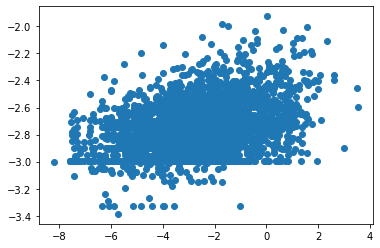

In [93]:
import matplotlib.pyplot as plt
plt.scatter(y_train, predicted_train)

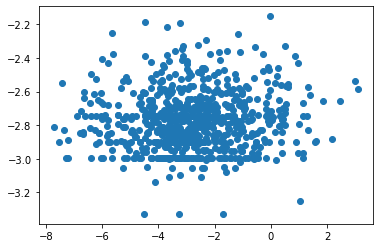

In [94]:
plt.scatter(y_test, predicted_test)